In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import torch
import xgboost as xgb
from sentence_transformers import SentenceTransformer
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import early_stopping, log_evaluation

In [5]:
##############################################
# 1) Embedding Model
##############################################
class EmbeddingModel:
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        """
        Load a SentenceTransformer model on GPU 
        if available (or CPU otherwise).
        """
        if device:
            self.device = device
        else:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = SentenceTransformer(model_name, device=self.device)

    def encode(self, texts, show_progress_bar=False):
        """
        Encode one string or a list of strings into a (n×d) numpy.float32 array.
        """
        # Normalize input to list
        inputs = [texts] if isinstance(texts, str) else texts
        embeddings = self.model.encode(inputs, show_progress_bar=show_progress_bar and len(inputs) > 1)
        return np.array(embeddings, dtype='float32')

In [7]:
##############################################
# 2) Load Data in Wide Format
##############################################
# Each CSV has rows = topics, columns = [2007..2025].
# We'll label them as train, val, test by topics (not year).
##############################################
print("Loading CSVs...")
train_wide = pd.read_csv("train_data_new.csv", index_col=0)
val_wide   = pd.read_csv("val_data_new.csv", index_col=0)
test_wide  = pd.read_csv("test_data_new.csv", index_col=0)

# Drop 2025 column if it exists
for df in [train_wide, val_wide, test_wide]:
    if "2025" in df.columns:
        df.drop(columns=["2025"], inplace=True)
        
print("Train shape:", train_wide.shape)
print("Val shape:  ", val_wide.shape)
print("Test shape: ", test_wide.shape)

Loading CSVs...
Train shape: (7921, 18)
Val shape:   (987, 18)
Test shape:  (987, 18)


In [9]:
##############################################
# 3) Sliding Window Function
##############################################
def generate_sliding_samples(wide_df, input_len, output_len):
    """
    wide_df: DataFrame with row=topic, cols= [2007..2025], numeric counts.
    input_len: how many years to use as input
    output_len: how many future years to predict
    Returns: a new DataFrame, each row is a sliding window sample with:
      f0..f(input_len-1) = the input counts
      y1..y(output_len)  = the future counts
      'topic': the topic name
      'last_input_year': the year of the final input
    """
    samples = []
    topics = wide_df.index
    
    # Convert the columns to strings to iterate easily
    year_cols = [str(c) for c in wide_df.columns]
    
    for topic in topics:
        row_values = wide_df.loc[topic].values.astype(float)  # all year counts
        n_years = len(row_values)
        
        # We'll assume columns are in ascending year order. If not, sort them first.
        # For i in range( n_years - (input_len+output_len) + 1 ):
        for i in range(n_years - input_len - output_len + 1):
            # Input slice
            x_slice = row_values[i : i + input_len]
            # Target slice
            y_slice = row_values[i + input_len : i + input_len + output_len]
            
            # The last input year's index
            # year index = i + input_len - 1 in zero-based offset
            final_input_index = (i + input_len - 1)
            
            # We'll store the actual numeric year from the columns
            last_input_year_str = year_cols[final_input_index]
            last_input_year = int(last_input_year_str)
            
            sample_dict = {}
            # Fill input
            for idx, val in enumerate(x_slice):
                sample_dict[f"f{idx}"] = val
            # Fill target
            for idx, val in enumerate(y_slice):
                sample_dict[f"y{idx+1}"] = val
            
            sample_dict["topic"] = topic
            sample_dict["last_input_year"] = last_input_year
            
            samples.append(sample_dict)
    
    out_df = pd.DataFrame(samples)
    return out_df

In [11]:

##############################################
# 4) Generate sliding samples for each subset
##############################################
input_len  = 5
output_len = 1

train_df = generate_sliding_samples(train_wide, input_len, output_len)
train_df = train_df[train_df["last_input_year"] <= 2021]
val_df   = generate_sliding_samples(val_wide,   input_len, output_len)
val_df = val_df[val_df["last_input_year"] == 2022]
test_df  = generate_sliding_samples(test_wide,  input_len, output_len)
test_df = test_df[test_df["last_input_year"] == 2023]

print("train_df shape:", train_df.shape)
print("val_df shape:  ", val_df.shape)
print("test_df shape: ", test_df.shape)

train_df shape: (86460, 8)
val_df shape:   (985, 8)
test_df shape:  (987, 8)


In [13]:
##############################################
# 5) Add year as a numeric feature, plus stats
##############################################
def add_basic_features(df, input_len):
    fcols = [f"f{i}" for i in range(input_len)]
    
    # Summary stats
    df["f_mean"] = df[fcols].mean(axis=1)
    df["f_std"]  = df[fcols].std(axis=1)
    df["f_min"] = df[fcols].min(axis=1)
    df["f_max"] = df[fcols].max(axis=1)
    df["f_last_minus_first"] = df[fcols[-1]] - df[fcols[0]]
    df["linear_trend"] = df[fcols].apply(lambda row: np.polyfit(range(len(row)), row, 1)[0], axis=1)
    df["slope_mean_ratio"] = df["linear_trend"] / (df["f_mean"] + 1e-8)
    
    # Year features
    df["norm_year"] = df["last_input_year"] - 2007
    df["norm_year_sq"] = df["norm_year"] ** 2

    # Deltas and recent patterns
    df["f_diff_1"] = df["f4"] - df["f3"]
    df["f_diff_2"] = df["f3"] - df["f2"]
    df["f_diff_3"] = df["f2"] - df["f1"]
    df["f_diff_4"] = df["f1"] - df["f0"]
    df["f_acceleration"] = (df["f4"] - df["f3"]) - (df["f3"] - df["f2"])
    df["f_rolling_mean_3"] = df[["f2", "f3", "f4"]].mean(axis=1)

    # Behavioral indicators
    df["f_last_to_mean_ratio"] = df["f4"] / (df["f_mean"] + 1e-8)
    df["last_year_jump_ratio"] = df["f4"] / (df["f3"] + 1e-8)
    df["is_flat"] = ((df["f4"] - df["f0"]).abs() < 200).astype(int)

    df["recent_growth_strength"] = df["f_diff_1"] * df["last_year_jump_ratio"]
    
    df["topic_size_bin"] = pd.cut(
        df["f_mean"], 
        bins=[-1, 1000, 3000, 7000, float("inf")], 
        labels=[0, 1, 2, 3]
    ).astype(int)


    return df

train_df = add_basic_features(train_df, input_len)
val_df   = add_basic_features(val_df,   input_len)
test_df  = add_basic_features(test_df,  input_len)

In [15]:
##############################################
# 6) Topic Embeddings
##############################################
embedding_model = EmbeddingModel(model_name='all-MiniLM-L6-v2')

all_topics = pd.concat([train_df["topic"], val_df["topic"], test_df["topic"]]).unique()
print("Embedding all topics (count:", len(all_topics), ") ...")

embeddings = embedding_model.encode(all_topics, show_progress_bar=True)

# Make a map: topic -> embedding
topic_to_emb = dict(zip(all_topics, embeddings))

def attach_embeddings(df):
    emb_list = [topic_to_emb[t] for t in df["topic"]]
    emb_cols = [f"emb_{i}" for i in range(embeddings.shape[1])]
    emb_df = pd.DataFrame(emb_list, columns=emb_cols, index=df.index)
    return pd.concat([df, emb_df], axis=1)

train_df = attach_embeddings(train_df)
val_df   = attach_embeddings(val_df)
test_df  = attach_embeddings(test_df)


Embedding all topics (count: 9832 ) ...


Batches:   0%|          | 0/308 [00:00<?, ?it/s]

In [23]:
##############################################
# 7) Prepare X, y for T+1
##############################################
# We'll train separate models for y1

# Fixed list of all non-embedding features
base_features = [
    "f0", "f1", "f2", "f3", "f4",
    "f_mean", "f_std", "f_min", "f_max",
    "f_last_minus_first", "linear_trend","slope_mean_ratio",
    "norm_year", "norm_year_sq",
    "f_diff_1", "f_diff_2", "f_diff_3", "f_diff_4",
    "f_acceleration", "f_rolling_mean_3", 
    "f_last_to_mean_ratio", "last_year_jump_ratio", "is_flat",
    "recent_growth_strength"
]

# Add topic embedding dimensions
embedding_features = [col for col in train_df.columns if col.startswith("emb_")]
input_features = base_features + embedding_features
input_features += ["topic_size_bin"]

def train_and_eval_lgbm(target_col, label):
    X_train = train_df[input_features]
    X_val   = val_df[input_features]
    X_test  = test_df[input_features]

    y_train = train_df[target_col]
    y_val   = val_df[target_col]
    y_test  = test_df[target_col]

    model = LGBMRegressor(
        objective='regression',
        learning_rate=0.05,
        max_depth=12,
        n_estimators=1000,
        reg_alpha=0.3,
        reg_lambda=1.0,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=1  # Optional: 0=silent, 1=info, 2=warning
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(100),
            log_evaluation(50)
        ]
    )

    preds = model.predict(X_test)

    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)

    print(f"{label} RMSE: {rmse:.2f}")
    print(f"{label} MAE:  {mae:.2f}")

    return model, preds

In [25]:
# Train model for T+1 (y1)
model_lgbm, pred_lgbm = train_and_eval_lgbm("y1", "T+1")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103305
[LightGBM] [Info] Number of data points in the train set: 86460, number of used features: 409
[LightGBM] [Info] Start training from score 2256.343141
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1636.96	valid_0's l2: 2.67965e+06
[100]	valid_0's rmse: 1454.93	valid_0's l2: 2.11682e+06
[150]	valid_0's rmse: 1440.78	valid_0's l2: 2.07586e+06
[200]	valid_0's rmse: 1440.23	valid_0's l2: 2.07427e+06
[250]	valid_0's rmse: 1441.99	valid_0's l2: 2.07933e+06
Early stopping, best iteration is:
[159]	valid_0's rmse: 1437.57	valid_0's l2: 2.06661e+06
T+1 RMSE: 3306.25
T+1 MAE:  2284.20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [200]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate predictions for train and val as well
pred_val_y1   = model_lgbm.predict(val_df[input_features]).round().astype(int)
pred_test_y1  = pred_lgbm.round().astype(int)  # you already computed pred_lgbm

# 1. Train: predict 2022
# ✅ 1. Filter train samples that predict 2022
train_2022 = train_df[train_df["last_input_year"] == 2021].copy()

# ✅ 2. Predict and round to int
pred_train_y1 = model_lgbm.predict(train_2022[input_features]).round().astype(int)

# ✅ 3. Export
train_out = pd.DataFrame({
    "topic": train_2022["topic"].values,
    "actual_2022": train_2022["y1"].astype(int),
    "predicted_2022": pred_train_y1
})
train_out.to_csv("train_predictions_2022.csv", index=False)


# 2. Validation: predict 2023
val_out = pd.DataFrame({
    "topic": val_df["topic"].values,
    "actual_2023": val_df["y1"].values,
    "predicted_2023": pred_val_y1
})
val_out.to_csv("val_predictions_2023.csv", index=False)

# 3. Test: predict 2024
test_out = pd.DataFrame({
    "topic": test_df["topic"].values,
    "actual_2024": test_df["y1"].values,
    "predicted_2024": pred_test_y1
})
test_out.to_csv("test_predictions_2024.csv", index=False)

print("✅ All 3 CSVs saved.")


✅ All 3 CSVs saved.


In [23]:
##############################################
# 8) Summaries or Save
##############################################
import numpy as np

# Combine final predictions
test_preds = pd.DataFrame({
    "topic": test_df["topic"],
    "last_input_year": test_df["last_input_year"],
    "y1_true": test_df["y1"],
    "y1_pred": pred_y1
})

rmse_i = mean_squared_error(test_preds["y1_true"], test_preds["y1_pred"], squared=False)
print(f"T+1 final test RMSE: {rmse_i:.2f}")

T+1 final test RMSE: 3850.17


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
# 你关心的5个topic
topics_of_interest = [
    "learning stability",
    "machine learning for security",
    "adaptive gradient methods",
    "attention economy",
    "tuberculosis detection and diagnosis"
]

# 统计每个topic在test_df中出现的次数
topic_counts = test_df['topic'].value_counts()

# 筛选出你关心的5个
for topic in topics_of_interest:
    count = topic_counts.get(topic, 0)  # 如果没有出现返回0
    print(f"Topic: {topic}, Count in test_df: {count}")

Topic: learning stability, Count in test_df: 1
Topic: machine learning for security, Count in test_df: 1
Topic: adaptive gradient methods, Count in test_df: 1
Topic: attention economy, Count in test_df: 1
Topic: tuberculosis detection and diagnosis, Count in test_df: 1


In [37]:
import time
import pandas as pd

# 读你之前保存好的test predictions文件
test_out = pd.read_csv("test_predictions_2024.csv")

# 关心的topics
topics_of_interest = [
    "learning stability",
    "machine learning for security",
    "adaptive gradient methods",
    "attention economy",
    "tuberculosis detection and diagnosis"
]

results = []

for topic in topics_of_interest:
    # 从保存好的预测结果里面拿到之前整体预测的数值
    row = test_out[test_out['topic'] == topic]
    if row.empty:
        print(f"Warning: Topic {topic} not found in test_out")
        continue
    predicted_saved = row['predicted_2024'].values[0]

    # 为了测latency + 预测数值（live），重新拿一条数据predict一下
    test_row = test_df[test_df['topic'] == topic].iloc[0]
    input_features_single = test_row.drop(['y1', 'last_input_year', 'topic']).values.reshape(1, -1)

    start_time = time.time()
    pred_live = model_lgbm.predict(input_features_single)[0]  # 拿单条预测值
    end_time = time.time()

    latency_sec = end_time - start_time
    latency_ms = latency_sec * 1000

    results.append({
        'Topic': topic,
        'Latency (ms)': round(latency_ms, 2),
        'Predicted Paper Count (live)': round(pred_live, 2),
        'Predicted Paper Count (saved)': int(round(predicted_saved))
    })

final_result_df = pd.DataFrame(results)
display(final_result_df)

,Topic,Latency (ms),Predicted Paper Count (live),Predicted Paper Count (saved)
0,learning stability,1.07,2314.69,2282
1,machine learning for security,0.97,2510.71,2489
2,adaptive gradient methods,1.09,4443.13,4455
3,attention economy,1.15,56.42,55
4,tuberculosis detection and diagnosis,0.71,44.19,40


In [25]:
test_df[["topic", "last_input_year", "y1"]].sort_values("y1", ascending=False).head()


,topic,last_input_year,y1
12401,user-generated content processing,2023,47391.0
10191,multi-label learning,2023,44227.0
324,learning-to-learn,2023,36536.0
1286,prefix-free coding,2023,35843.0
6161,efficient on-device inference,2023,35778.0


NameError: name 'plt' is not defined

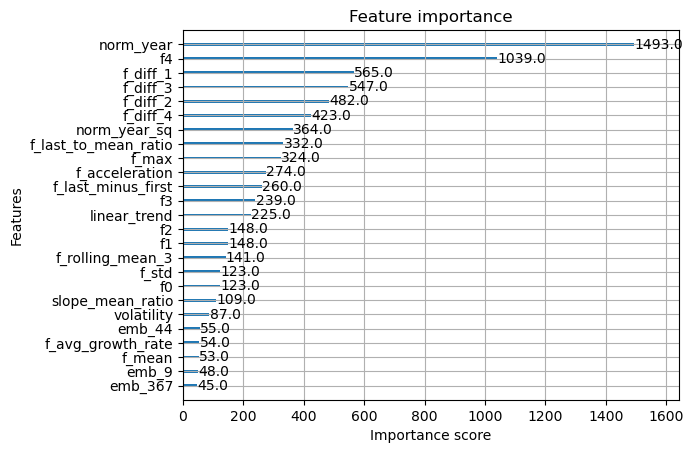

In [50]:
xgb.plot_importance(model_y1, max_num_features=25)
plt.tight_layout()
plt.show()
    df["last_year_jump_ratio"] = df["f4"] / (df["f3"] + 1e-8)



In [ ]:
def train_and_eval(target_col, label):
    # Extract X, y
    X_train = train_df[input_features]
    y_train = train_df[target_col]
    
    X_val   = val_df[input_features]
    y_val   = val_df[target_col]
    
    X_test  = test_df[input_features]
    y_test  = test_df[target_col]

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test)

    # Parameters
    params = {
        "objective": "reg:squarederror",
        "learning_rate": 0.03,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 0.3,
        "reg_lambda": 1.0,
        "eval_metric": "rmse",
        "seed": 42
    }

    # Watchlist for early stopping
    evals = [(dtrain, "train"), (dval, "val")]

    # Train with early stopping
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=evals,
        early_stopping_rounds=200,
        verbose_eval=50
    )

    # Predict and reverse log1p
    preds = booster.predict(dtest)
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    print(f"{label} RMSE: {rmse:.2f}")
    print(f"T+1 MAE: {mae:.2f}")
    
    return booster, preds

In [ ]:
model_y1, pred_y1 = train_and_eval("y1", "T+1")

In [220]:
for topic in train_wide.index.unique():
    rows = train_wide.loc[[topic]]  # always returns a DataFrame (even if one row)
    
    for i, row in rows.iterrows():
        values = row.loc[["2017", "2018", "2019", "2020", "2021", "2022"]]

        # ✅ Check for missing
        if pd.isnull(values).any():
            print(f"❌ Missing data for topic: {topic}")
        
        # ✅ Check if inputs (2017–2021) are all zero
        elif values.loc[["2017", "2018", "2019", "2020", "2021"]].sum() == 0:
            print(f"⚠️ All-zero input from 2017–2021: {topic}")


        



In [222]:
topic_counts = train_wide.index.to_series().value_counts()
duplicates = topic_counts[topic_counts > 1]
print(f"Number of duplicated topic names: {len(duplicates)}")
print(duplicates.head(10))


Number of duplicated topic names: 30
topic
e-learning                             3
parallel computing                     2
semi-supervised learning               2
multi-armed bandits                    2
rate adaptation                        2
privacy-preserving machine learning    2
high-dimensional data                  2
education                              2
zero-shot learning                     2
statistical modeling                   2
Name: count, dtype: int64


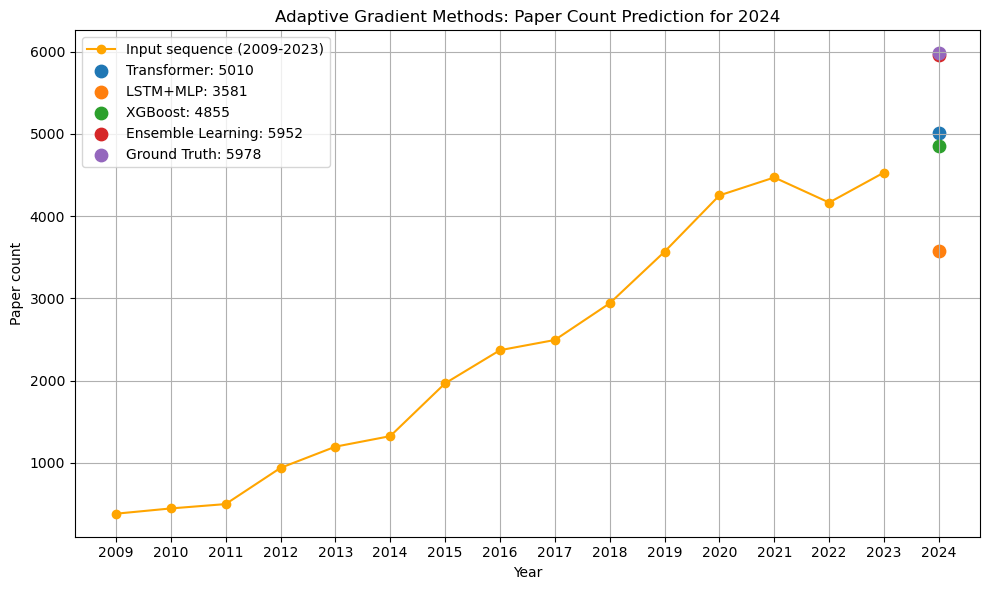

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# 输入数据
input_sequence = np.array([381., 445., 498., 938., 1196., 1324., 1966., 2369., 2493., 2939., 3566., 4251., 4469., 4164., 4529.])

# 预测数据
predictions_2024 = {
    "Transformer": 5010,
    "LSTM+MLP": 3581,
    "XGBoost": 4855,
    "Ensemble Learning": 5952,
    "Ground Truth": 5978
}

# 年份标签
years = np.arange(2009, 2024)  # 2009到2023共15年
year_2024 = 2024

# 画图
plt.figure(figsize=(10,6))

# 画输入序列
plt.plot(years, input_sequence, marker='o', color='orange', label="Input sequence (2009-2023)")

# 在2024年画出不同模型的预测
for model, pred_value in predictions_2024.items():
    plt.scatter(year_2024, pred_value, label=f"{model}: {pred_value}", s=80)

plt.title("Adaptive Gradient Methods: Paper Count Prediction for 2024")
plt.xlabel("Year")
plt.ylabel("Paper count")
plt.xticks(np.arange(2009, 2025, 1))  # x轴显示2009到2024
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

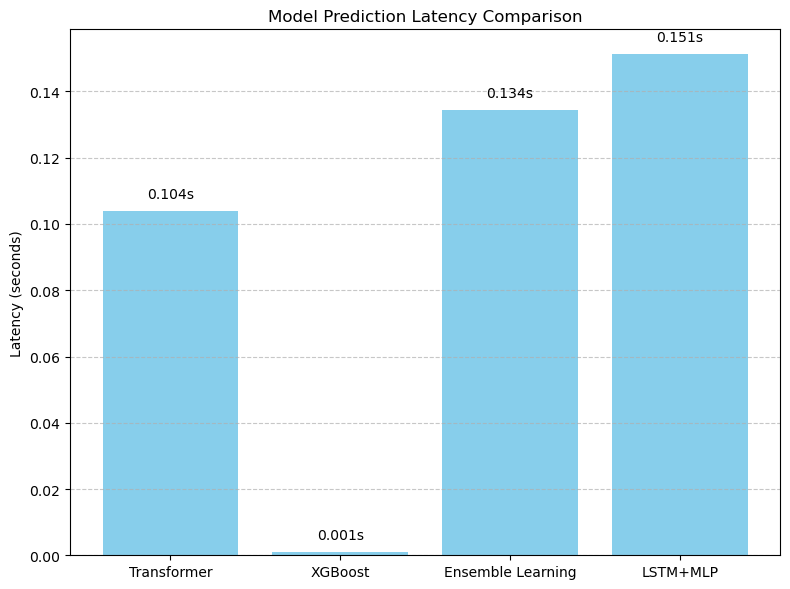

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# 模型名字和对应的延迟（单位是秒）
models = ["Transformer", "XGBoost", "Ensemble Learning", "LSTM+MLP"]
latencies = [0.104, 0.00109, 0.134435, 0.1512]

# 画柱状图
plt.figure(figsize=(8,6))
bars = plt.bar(models, latencies, color='skyblue')

# 在每个柱子上标数值
for bar, latency in zip(bars, latencies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.003, f"{yval:.3f}s", ha='center', va='bottom')

plt.title("Model Prediction Latency Comparison")
plt.ylabel("Latency (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()